# Sanity Check for Bandit Sequence Design

In this notebook, we show the sanity check for bandit sequence design.   
The RBS sequence is 20-base, and we divide it into three parts: 7-base (Pre) + 6-base (Center) + 7-base (Post).  For the central part, we use spectrum kernel (l = 3), and for the other parts, we use dot product with one-hot encoding. Then the kernel matrix of 20-based RBS is the sum of the three kernels, i.e. K(rbs_i, rbs_j) = k_dotpro (pre_i, pre_j) + k_spectrum (center_i, center_j) + k_dotpro (post_i, post_j). The reason for summing up the kernels is that the central part is the design part and the other parts are similar in terms of different data points. 

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import product
import math

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels import spectrum_kernel
from codes.kernels_pairwise import spectrum_kernel_pw, sum_onehot_spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading Dataset

In [2]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

# A: whole RBS sequence (len: 29)
# B: extracted 20-base RBS seqeunce (A[7:27], len: 20), training features
# C: TIR labels
# D: the design part RBS (B[7:13], len: 6) 

Path = '../data/RBS_seqs.csv'

df = pd.read_csv(Path)
df.columns = ['A', 'B', 'C']
df['D'] = df['B'].str[7:13]
df.head()

,A,B,C,D
0,ACGATCTTAAGTAAGCGGGGAAAATAATG,TTAAGTAAGCGGGGAAAATA,57706,AGCGGG
1,ACGATCTTAAGTAGACGCGGAAAATAATG,TTAAGTAGACGCGGAAAATA,613,GACGCG
2,ACGATCTTAAGTAAGCGCGGAAAATAATG,TTAAGTAAGCGCGGAAAATA,5313,AGCGCG
3,ACGATCTTAAGTAAACGAGGAAAATAATG,TTAAGTAAACGAGGAAAATA,19594,AACGAG
4,ACGATCTTAAGTAGGCGAGGAAAATAATG,TTAAGTAGGCGAGGAAAATA,33626,GGCGAG


In [3]:
# drop the exact same record (same B and C)

df = df.drop_duplicates(subset = ['B', 'C'])
df.shape

(113, 4)

In [4]:
Log_flag = False # indicates whether take log label
Norm_method = 'minmax' # indicates how to normalize label (one of 'mean', 'minmax', None)

def normalize(df):
    # take log FC -- possiblely provide Gaussain distribution?
    if Log_flag:
        df['C'] = np.log(df['C'])
    if Norm_method == 'mean':
        # mean normalization
        df['C'] = (df['C'] - df['C'].mean())/df['C'].std()
    elif Norm_method == 'minmax':
        # min-max normalization [-1,1]
        df['C'] = (df['C'] - df['C'].min())/(df['C'].max() - df['C'].min())
    else:
        assert Norm_method == None
        
    return df

In [5]:
# data: num_data * 2, columns: [20-base RBS seq (B), TIR labels (C)]
data = np.asarray(normalize(df)[['B', 'C']])
data.shape

(113, 2)

In [6]:
# data6: num_data * 2, columns: [6-base RBS seq (D), TIR labels (C)]
data6 = np.asarray(normalize(df)[['D', 'C']])
data6.shape

(113, 2)

## Construct feature spaces

We fix the part other the designing 6-base RBS, the 20-based RBS would be: 'TTTAAGA' + 6-base design + 'TATACAT'. The 6-base design has totally 4^6 = 4096 combinations.

In [7]:
# create all combos

combos = [] # 20-base
combos_6 = [] # 6-base
labels = []
char_sets = ['A', 'G', 'C', 'T']
design_len = 6

# to be changed
pre_design = 'TTTAAGA'
pos_design = 'TATACAT'

for combo in product(char_sets, repeat= design_len):
    combos_6.append(''.join(combo))
    combo = pre_design + ''.join(combo) + pos_design
    combos.append(combo)
    labels.append(math.inf)
    
assert len(combos) == len(char_sets) ** design_len

In [8]:
todesign_data = np.asarray(list(zip(combos, labels))) # 20-base
todesign6_data = np.asarray(list(zip(combos_6, labels))) # 6-base

## Setting

In [9]:
embedding = 'label'
# sum_spectrum_kernel_pw: spectrum kernels for [:7], [7:13], [13:] respectively
kernel = [spectrum_kernel, sum_onehot_spectrum_kernel_pw]
string_kernel_flag = True

### 1. Check influence of the parameters of kernels. 

Check whether changing the parameters of kernels by a small amount changes the recommendations dramatically.
But since we use spectrum kernel for the main part, the only parameter is the l (the length of features) and we fixed it to 3. There is not much to test.

### 2. Check whether permutating the data change the recommendations.

[1684  916 3667 2382 2381 1940 2643 3076 2352 3822  546  819 3003 1911
 3276 3549 2184 3091 2820 3844  772 1508 1476 1284 1364 1363 1359 1358
 1357 1356 1334 1342 1341 1340 1335 1338 1339 1337 1329 1330 1331 1336
 1332 1343 2724 4092 4093 2047 3071 2731 2729 2728 4094 1706 1023  682
 3754 1328 2730 4095]


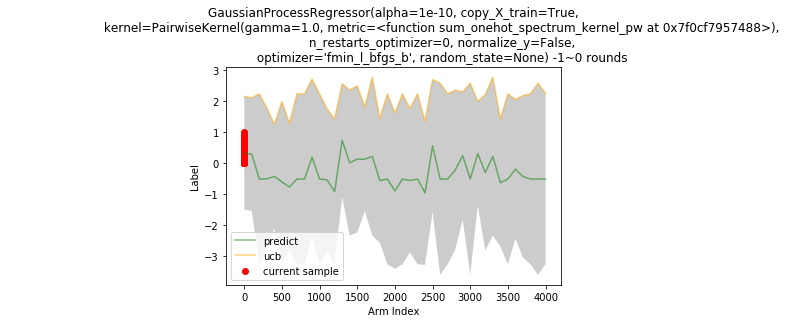

In [10]:
num_rounds = 1
num_exper = 1
num_rec = 60

my_env = Rewards_env(data, embedding)
new_env = Rewards_env(todesign_data, embedding)
if string_kernel_flag:
    agent = GPUCB(new_env, num_rounds, init_list = my_env.rewards_dict, num_rec = num_rec,
              model = GaussianProcessRegressor(kernel = PairwiseKernel(metric = kernel[-1])))
else:
    agent = GPUCB(new_env, num_rounds, init_list = my_env.rewards_dict, num_rec = num_rec,
              model = GaussianProcessRegressor(kernel = kernel[-1]))
rec_arms = agent.play(label_avaiable = False)

In [11]:
from sklearn.utils import shuffle
shuffled_df = shuffle(df)
shuffled_df.reset_index(inplace=True, drop=True)

In [12]:
# data: num_data * 2, columns: [20-base RBS seq (B), TIR labels (C)]
shuffled_data = np.asarray(normalize(shuffled_df)[['B', 'C']])

# data6: num_data * 2, columns: [6-base RBS seq (D), TIR labels (C)]
shuffled_data6 = np.asarray(normalize(shuffled_df)[['D', 'C']])

[1684  916 3667 2382 2381 1940 2643 3076 2352 3822  546  819 3003 1911
 3276 3549 2184 3091 2820 3844  772 1508 1476 1284 1364 1363 1359 1358
 1357 1356 1334 1342 1341 1340 1335 1338 1339 1337 1329 1330 1331 1336
 1332 1343 2724 4092 4093 2047 3071 2731 2729 2728 4094 1706 1023  682
 3754 1328 2730 4095]


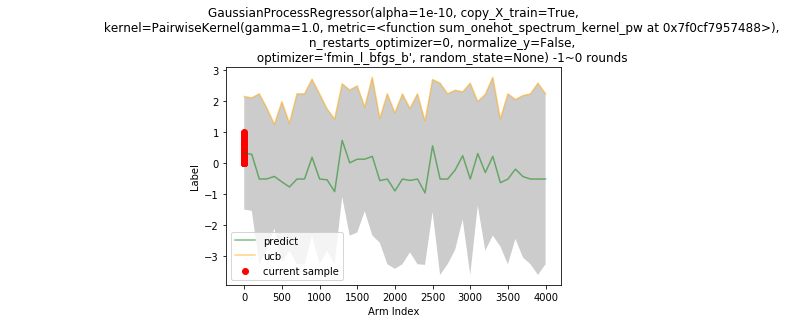

In [13]:
num_rounds = 1
num_exper = 1
num_rec = 60

my_env = Rewards_env(shuffled_data, embedding)
new_env = Rewards_env(todesign_data, embedding)
if string_kernel_flag:
    agent_with_shuffle_data = GPUCB(new_env, num_rounds, init_list = my_env.rewards_dict, num_rec = num_rec,
              model = GaussianProcessRegressor(kernel = PairwiseKernel(metric = kernel[-1])))
else:
    agent_with_shuffle_data = GPUCB(new_env, num_rounds, init_list = my_env.rewards_dict, num_rec = num_rec,
              model = GaussianProcessRegressor(kernel = kernel[-1]))
rec_arms_with_shuffled_data = agent_with_shuffle_data.play(label_avaiable = False)

In [14]:
set(rec_arms) == set(rec_arms_with_shuffled_data)

True

#### Conclusion 2. 
From the above experiment, shuffling data does not change the recommendations. 

### 3. Check the kernel matrix of the Bandit Top60 vs 1by1 sequences. 

Since the designed bandit sequences use about 1/3 same pre- and post- sequences as the 1by1 sequences, it's kind of cheating to test the similarities for the whole sequence. We provide the plot for both: 1) kernel matrix for 20-base bandit vs. 1by1; 2) kernel matrix for only 6-base central part for bandit vs. 1by1. 

#### 1) kernel matrix for 20-base bandit vs. 1by1

In [15]:
rbs1by1seq = pd.read_csv('../data/1by1_recs.csv')
rbs1by1 = np.asarray(rbs1by1seq['1by1'].str.upper())

[[0.         0.         0.2236068  ... 0.         0.         0.2236068 ]
 [0.         0.         0.2236068  ... 0.         0.         0.2236068 ]
 [0.         0.         0.21320072 ... 0.         0.         0.21320072]
 ...
 [0.         0.         0.19611614 ... 0.         0.         0.19611614]
 [0.         0.         0.18257419 ... 0.         0.         0.18257419]
 [0.         0.         0.14142136 ... 0.         0.         0.84852814]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.40824829 0.40824829 0.40824829 ... 0.40824829 0.40824829 0.40824829]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.20412415 0.         0.         ... 0.20412415 0.20412415 0.20412415]]


Text(0, 0.5, 'Bandit')

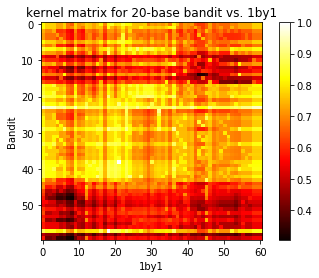

In [16]:
rbs1by1_bandit_kernel = spectrum_kernel(todesign_data[np.asarray(rec_arms)][:,0], np.asarray(rbs1by1))
plt.imshow(rbs1by1_bandit_kernel, cmap = 'hot', interpolation='nearest')
#plt.imshow(sorted_new_kernel_matrix, cmap = 'hot')
plt.colorbar()
plt.title('kernel matrix for 20-base bandit vs. 1by1')
plt.xlabel('1by1')
plt.ylabel('Bandit')

#### 2) kernel matrix for only 6-base central part for bandit vs. 1by1. 

In [17]:
rbs1by1_6 = np.asarray(rbs1by1seq['1by1'].str[7:13].str.upper())
rbs1by1_6

array(['AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA',
       'AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA',
       'AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA',
       'AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA', 'CGGAGA', 'GGGAGA',
       'TGGAGA', 'ACGAGA', 'AAGAGA', 'ATGAGA', 'AGCAGA', 'AGAAGA',
       'AGTAGA', 'AGGCGA', 'AGGGGA', 'AGGTGA', 'AGGACA', 'AGGAAA',
       'AGGATA', 'AGGAGC', 'AGGAGG', 'AGGAGT', 'AGGAGA', 'AGGAGA',
       'AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA',
       'AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA',
       'AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA', 'AGGAGA',
       'AGGAGA'], dtype=object)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Text(0, 0.5, 'Bandit')

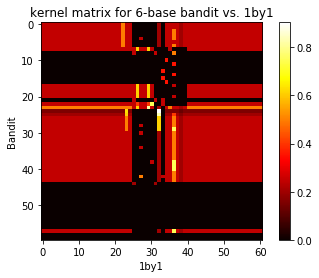

In [18]:
rbs1by1_bandit_kernel = spectrum_kernel(todesign6_data[np.asarray(rec_arms)][:,0], np.asarray(rbs1by1_6))
plt.imshow(rbs1by1_bandit_kernel, cmap = 'hot', interpolation='nearest')
#plt.imshow(sorted_new_kernel_matrix, cmap = 'hot')
plt.colorbar()
plt.title('kernel matrix for 6-base bandit vs. 1by1')
plt.xlabel('1by1')
plt.ylabel('Bandit')

#### Ps. Random recs vs. 1by1 seqs

[[0.  0.  0.  ... 0.  0.5 0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.5 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.5 0. ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Text(0, 0.5, 'Random')

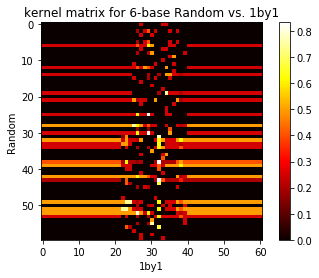

In [19]:
random_recs = pd.read_csv('../data/random_recs.csv')
random = np.asarray(random_recs['uniform'].append(random_recs['ppm']))

random_rbs1by1_kernel = spectrum_kernel(random, np.asarray(rbs1by1_6))
plt.imshow(random_rbs1by1_kernel, cmap = 'hot', interpolation='nearest')
#plt.imshow(sorted_new_kernel_matrix, cmap = 'hot')
plt.colorbar()
plt.title('kernel matrix for 6-base Random vs. 1by1')
plt.xlabel('1by1')
plt.ylabel('Random')

#### Conclusion 3.

As expected, similarities between 20-base sequences are high. For the 6-base comparison, we show two plots: bandit (y-axis) vs. 1by1 (x-axis); random (y-axis) vs. 1by1 (x-axis). The 1-30 random sequences are uniformly random, and 31-60 are random based on PPM. We can see the similarity of PPM random vs. 1by1 is generally higher than uniform random vs. 1by1. And the similarity of bandit vs. 1by1 is bewteen the above two random designs, which makes sense (bandit is desinged to recommend seqeucnes tends to have higher predictions or with high uncertainty).  

### 4. Clustering the Top60 recommendations (we expect there are a few clusters)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


Text(0.5, 1.0, 'kernel matrix for 6-base bandit (Top 60 UCB)')

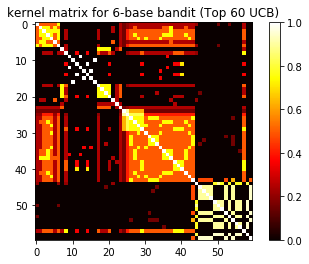

In [20]:
bandit_kernel = spectrum_kernel(todesign6_data[np.asarray(rec_arms)][:,0])
plt.imshow(bandit_kernel, cmap = 'hot', interpolation='nearest')
#plt.imshow(sorted_new_kernel_matrix, cmap = 'hot')
plt.colorbar()
plt.title('kernel matrix for 6-base bandit (Top 60 UCB)')

#### Conclusion 4.

Actually, before any clustering, the recommendation sequences are already shown in several blocks in the kernel heatmap plot. The recommendations are actually sorted in terms of the UCB (mu + sigma) in decreasing order. The first 10 arms are similar to each other within the small group, so are 10-20, 20-40, 40-60 groups.     
One thing to notice is that the 20-40 arms are also similar to 1-10.  
So there are roughly 4-5 clusters among the Top 60 arms. This is good. On the one hand, arms are not all similar to each other; on the other hand, arms are all not relevant to each other.

### 5. Check the intersection of recommendations based on mu, mu+sigma, sigma 

Ideally, there should be some interactions but not a lot. We use the [jaccard similarity](https://en.wikipedia.org/wiki/Jaccard_index) score and kernel matrix to show the interactions. 

In [21]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [22]:
recs_mu = np.asarray(sorted(range(len(agent.mu)), key=lambda k: (agent.mu)[k]))[-60:]
recs_sigma = np.asarray(sorted(range(len(agent.sigma)), key=lambda k: (agent.sigma)[k]))[-60:]

In [23]:
jaccard_similarity(recs_mu, rec_arms)

0.2765957446808511

In [24]:
jaccard_similarity(recs_sigma, rec_arms)

0.22448979591836735

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[[0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.5 0.  0.5]
 [0.  0.  0.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]
 [0.  0.  0.  ... 0.  0.  0. ]]


Text(0.5, 0, 'Top mu')

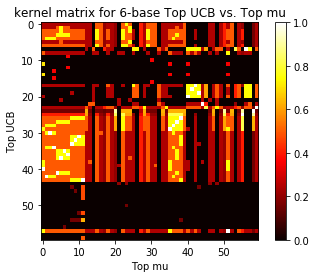

In [25]:
bandit_kernel = spectrum_kernel(todesign6_data[np.asarray(rec_arms)][:,0], todesign6_data[np.asarray(recs_mu)][:,0])
plt.imshow(bandit_kernel, cmap = 'hot', interpolation='nearest')
#plt.imshow(sorted_new_kernel_matrix, cmap = 'hot')
plt.colorbar()
plt.title('kernel matrix for 6-base Top UCB vs. Top mu')
plt.ylabel('Top UCB')
plt.xlabel('Top mu')


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.31622777 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.81649658 ... 0.9486833  0.         1.        ]]


Text(0.5, 0, 'Top sigma')

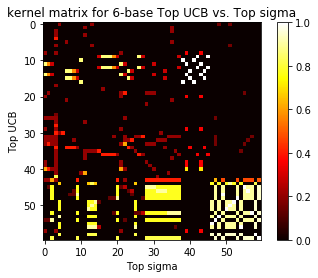

In [26]:
bandit_kernel = spectrum_kernel(todesign6_data[np.asarray(rec_arms)][:,0], todesign6_data[np.asarray(recs_sigma)][:,0])
plt.imshow(bandit_kernel, cmap = 'hot', interpolation='nearest')
#plt.imshow(sorted_new_kernel_matrix, cmap = 'hot')
plt.colorbar()
plt.title('kernel matrix for 6-base Top UCB vs. Top sigma')
plt.ylabel('Top UCB')
plt.xlabel('Top sigma')

#### Conclusion 5. 

Measuring the intersections might not be a good idea, since sorting the total more than 4,000 sequences by different metrics will highly possibly lead to very different sorting. Then the intersections will be small. But the intersection cannot take similar arms into consideration. That is, if different metrics return similar but not the same arms, then the effect of recommendation is similar as well, but the Jaccard score will be small. 

So we plot the kernel matrix for "Top UCB vs. Top mu", and "Top UCB vs. Top sigma". The plot is pretty interesting. The similarity trend for these two groups is on the contrary. 1-10, 20-40 arms for UCB are similar to top mu arms; 10-20, 40-60 arms for UCB are similar to top sigma arms. This trend can be explained by that the UCB recommendations combine mu and sigma, try to balance the exploration and exploitation. 

Note that most of the highly ranked UCB arms are similar to top mu groups. This shows the front part of Top 60 UCB recommendations prefers the high predictions mean (mu), which controls the exploitation; and the back part of Top 60 UCB arms are similar to the top sigma group, which leads the exploration.   